# EE 595 Assignment 3

* Student: John Rizzo
* Teacher: Shucheng Yu
* Assignment: EE 595 Assignment 3
* Due: 06/08/25

## Preamble

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree #sklearn.metrics is not imported !!!
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
RANDOM_STATE=20036833

In [3]:
# Read the Titanic dataset from a CSV file
titanic = pd.read_csv('./Titanic.csv')

# Display the first few rows of the dataframe
titanic.head()

,Unnamed: 0,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1st,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.337494,B5,Southampton,2,NaN,"St Louis, MO"
1,2,1st,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.550003,C22 C26,Southampton,11,NaN,"Montreal, PQ / Chesterville, ON"
2,3,1st,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,4,1st,0,"Allison, Mr. Hudson Joshua Crei",male,30.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,5,1st,0,"Allison, Mrs. Hudson J C (Bessi",female,25.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"


# Step 1

In [4]:
def QuantileBinning(feature, bin_number):
    """
    This function takes a numerical feature and the number of bins, and
    returns the feature binned into quantile-based bins.

    Parameters:
    - feature (pandas.Series): The numerical feature to be binned.
    - bin_number (int): The number of quantile bins.

    Returns:
    - pandas.Series: A series of discrete features binned by quantile.
    """
    # Use qcut to create quantile-based bins for the feature
    # If there are fewer unique values than bins, qcut could throw an error.
    # 'duplicates' parameter handles this by dropping redundant bins.
    return pd.qcut(feature, q=bin_number, labels=False, duplicates='drop')

# One example
feature_test = pd.DataFrame(np.random.rand(100),  columns=['Column_A'])
feature_test_discrete = QuantileBinning(feature_test['Column_A'], 10)

def label_encoder(feature):
    unique_labels = pd.unique(feature)
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    transformed_feature = np.array([label_to_int[label] for label in feature])
    return transformed_feature

In [5]:
# Identify numeric columns in the titanic dataframe
numeric_cols = titanic.select_dtypes(include=[np.number]).columns

# Fill missing values in each numeric column with the mean of that column
for col in numeric_cols:
    titanic[col] = titanic[col].fillna(titanic[col].mean())

In [6]:
# Set the features
feature_cols = ['pclass', 'sex', 'age', 'sibsp']
X = titanic[feature_cols]

# Set y as the target variable
y = titanic['survived']


In [7]:
# Discretize the age feature into 10 quantile-based bins
X_discrete = QuantileBinning(X['age'], 10)
X_discrete = pd.concat([X_discrete, X[['pclass', 'sex', 'sibsp']]], axis=1)

# Encode the pclass from 1st/2nd/3rd to 0/1/2
X_discrete['pclass'] = label_encoder(X['pclass'])

# Encode the sex from male/female to 0/1
X_discrete['sex'] = label_encoder(X['sex'])

In [8]:
# Split the data into 80% training and 20% test sets
X_train, X_test, y_train, y_test = train_test_split(X_discrete, y, test_size=0.2, random_state=RANDOM_STATE)

In [9]:
X_train.head()

,age,pclass,sex,sibsp
110,5,0,1,0
1069,4,2,1,1
388,3,1,0,0
274,7,0,1,1
178,7,0,0,1


# Step 2

In [10]:
# define your entropy function and information gain function

In [11]:
def entropy(y):
    """Calculate the entropy of a label array y."""
    values, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return -np.sum(probabilities * np.log2(probabilities + 1e-9))

In [12]:
def information_gain(X, y, feature):
    """Calculate the information gain of a feature in X with respect to y."""
    total_entropy = entropy(y)
    values, counts = np.unique(X[feature], return_counts=True)
    weighted_entropy = 0
    for v, count in zip(values, counts):
        subset_y = y[X[feature] == v]
        weighted_entropy += (count / len(y)) * entropy(subset_y)
    return total_entropy - weighted_entropy

In [13]:
# Calculate Information Gain for each feature in the training set
info_gains = {}
for col in X_train.columns:
    info_gains[col] = information_gain(X_train, y_train, col)

In [14]:
info_gains

{'age': np.float64(0.025055928670795424),
 'pclass': np.float64(0.06754835269545512),
 'sex': np.float64(0.1881473723889927),
 'sibsp': np.float64(0.030507212853505217)}

So the first split should be "sex"

# Step 3

In [15]:
# Instantiate the DecisionTreeClassifier
decision_tree_classifier = DecisionTreeClassifier(random_state=RANDOM_STATE, max_leaf_nodes=20)

# Fit the decision tree model
decision_tree_classifier.fit(X_train, y_train)


DecisionTreeClassifier(max_leaf_nodes=20, random_state=20036833)

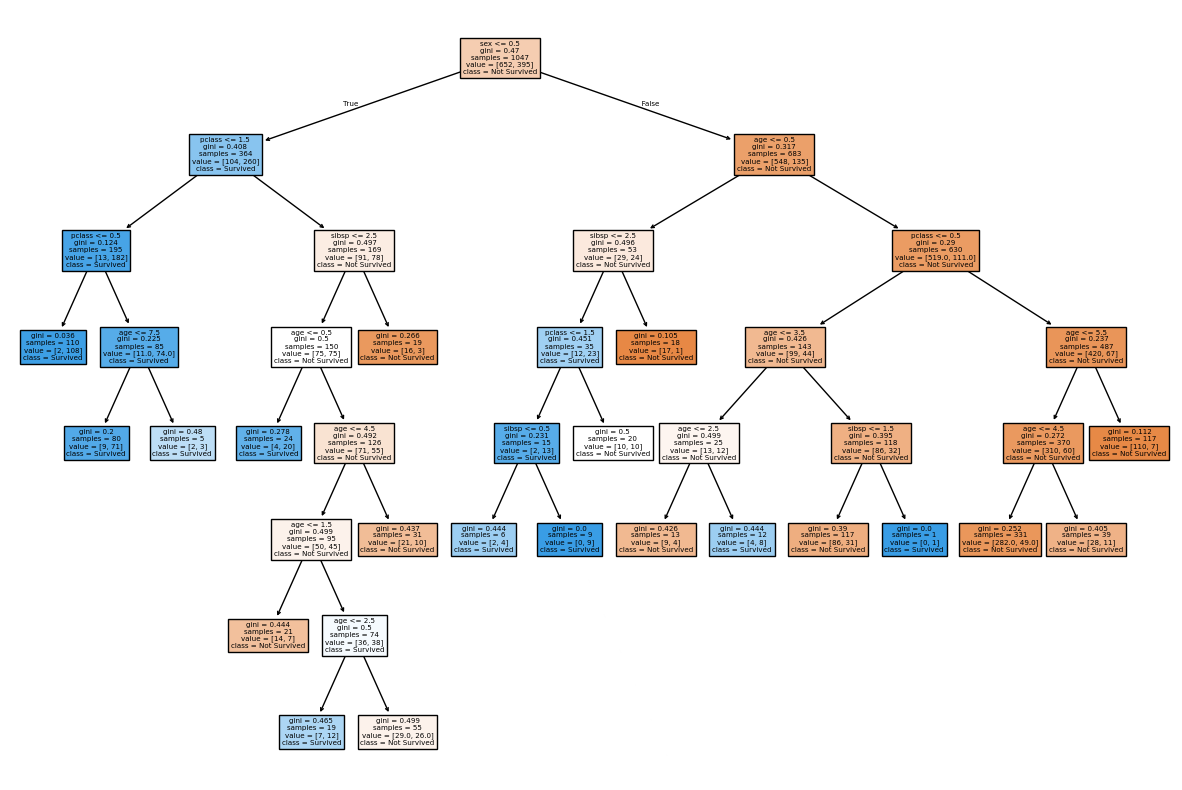

In [16]:
# Plot the full decision tree
plt.figure(figsize=(15, 10))
plot_tree(decision_tree_classifier, filled=True, feature_names=X_train.columns, class_names=['Not Survived', 'Survived'])
plt.show()

In [17]:
# Define your performance metrics including accuracy, precision, recall and F1-scorre
def performance_metrics(y_true, y_pred):
    """
    Calculate and return accuracy, precision, recall, and F1-score.
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

In [18]:
y_pred = decision_tree_classifier.predict(X_test)
print(performance_metrics(y_test, y_pred))

{'accuracy': 0.7748091603053435, 'precision': 0.8194444444444444, 'recall': 0.5619047619047619, 'f1_score': 0.6666666666666666}


# Step 4

Best Parameters: {'max_leaf_nodes': 8}
{'accuracy': 0.7709923664122137, 'precision': 0.8082191780821918, 'recall': 0.5619047619047619, 'f1_score': 0.6629213483146067}


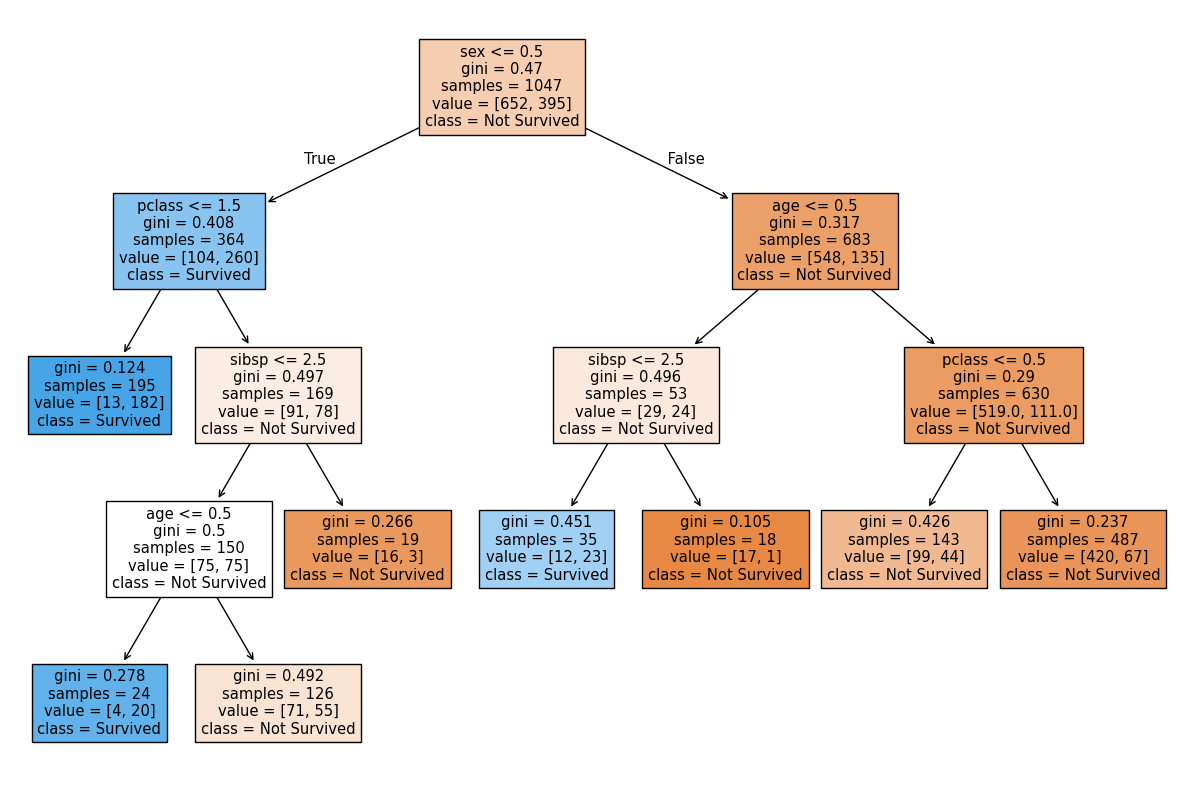

In [30]:
# Define a range of max_leaf_nodes values to search
param_grid = {'max_leaf_nodes': list(range(5, 20))}

# Run grid search with cross-validation
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE), param_grid, cv=5)
grid_search.fit(X_train, y_train) # Note testing set cannot be used

# Get the best estimator with the optimal max_leaf_nodes parameter
best_estimator = grid_search.best_estimator_
grid_search.best_estimator_
# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Plot the pruned decision tree
y_pred = best_estimator.predict(X_test)
print(performance_metrics(y_test, y_pred))

# Plot the pruned decision tree
plt.figure(figsize=(15, 10))
plot_tree(best_estimator, filled=True, feature_names=X_train.columns, class_names=['Not Survived', 'Survived'])
plt.show()


# Step 5


In [26]:
## it's an example (max_depth)
best_tree = grid_search.best_estimator_
dt_opt_criteria = DecisionTreeClassifier(criterion="entropy", random_state=RANDOM_STATE)
dt_opt_criteria.fit(X_train, y_train)
dt_max_depth = DecisionTreeClassifier(max_depth=25, random_state=RANDOM_STATE)
dt_max_depth.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=25, random_state=20036833)

In [28]:
def ensemble_vote(models, X):
    """
    Perform majority voting for an ensemble of models.
    For each sample, if there is a tie, choose the class with the highest index.
    """
    # Get predictions from each model (shape: n_models x n_samples)
    predictions = np.array([model.predict(X) for model in models])
    # Transpose to shape: n_samples x n_models
    predictions = predictions.T
    # For each sample, count votes for each class
    ensemble_predictions = []
    for sample_preds in predictions:
        counts = np.bincount(sample_preds)
        # Find the class(es) with the maximum votes
        max_vote = counts.max()
        winning_classes = np.where(counts == max_vote)[0]
        # If tie, pick the class with the highest index
        ensemble_predictions.append(winning_classes[-1])
    return np.array(ensemble_predictions)

In [29]:
# Use the defined function to get predictions from the ensemble of the three trees
models = [best_tree, dt_max_depth, dt_opt_criteria]

ensemble_predictions = ensemble_vote(models, X_test)

# Calculate performance metrics for the ensemble using the previously defined function
print(performance_metrics(y_test, ensemble_predictions))

{'accuracy': 0.7900763358778626, 'precision': 0.7976190476190477, 'recall': 0.638095238095238, 'f1_score': 0.708994708994709}


In [ ]:
# Train a random forest model using the optimal tree you found in step 4 and compare the ensembled model with the random forest 

In [31]:
rando = RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE)
rando.fit(X_train, y_train)
y_pred = rando.predict(X_test)
print(performance_metrics(y_test, y_pred))

NameError: name 'RandomForestClassifier' is not defined